In [15]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

# 1. Visualization

## 1.1. Wave and spectrogram

In [42]:
train_audio_path = 'C://Users/User/ML/data/train/audio/'
filename = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path)+filename)

In [66]:
print('sample rate : {}, samples.shape : {}'.format(sample_rate, samples.shape))

sample rate : 16000, samples.shape : (16000,)


In [67]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    # nperseg: Length of each segment
    # noverlap: Number of points to overlap between segments
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio, fs=sample_rate,
                                            window='hann', nperseg=nperseg,
                                            noverlap=noverlap, detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

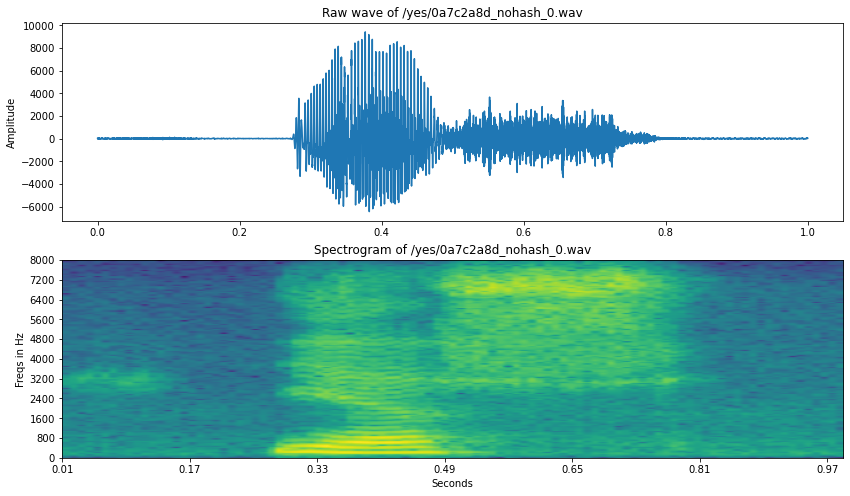

In [68]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [70]:
import IPython.display as ipd
import plotly.graph_objs as go

data = [go.Surface(x=times, y=freqs, z=spectrogram.T)]
layout = go.Layout(
    autosize=False,
    width=800, height=600,
    title = 'Spectrogram of "yes" in 3D',
    scene = dict(
        yaxis = dict(title='Frequencies', range=[freqs.min(), freqs.max()]),
        xaxis = dict(title='Time', range=[times.min(), times.max()]),
        zaxis = dict(title='Log amplitude')
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [71]:
print('{} ~ {}'.format(spectrogram.min(), spectrogram.max()))

-19.38099479675293 ~ 11.731490135192871


In [72]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std
spectrogram.shape

(99, 161)

## 1.2. MFCC

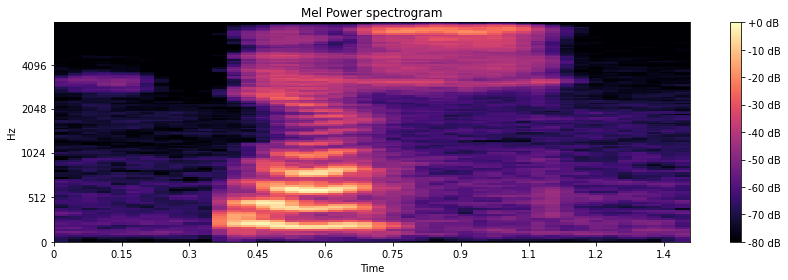

In [77]:
librosa_samples, librosa_sample_rate = librosa.load(str(train_audio_path)+filename)
S = librosa.feature.melspectrogram(librosa_samples, sr=librosa_sample_rate, n_mels=128, fmax=8000)

# log scale 전환(dB). peak power(max)만을 사용할 것.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel Power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

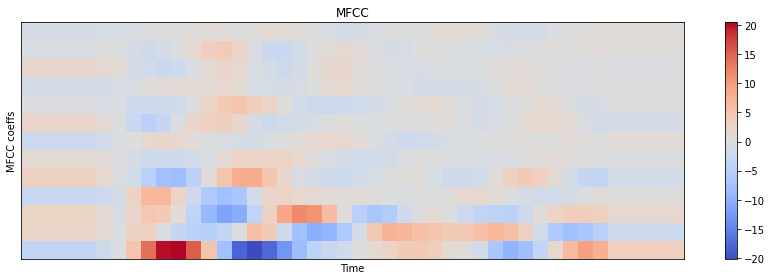

In [78]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

## 1.3. Spectrogram in 3d

In [80]:
data = [go.Surface(x=times, y=freqs, z=spectrogram.T)]
layout = go.Layout(
title='Specgtrogram of "yes" in 3d',
scene = dict(
yaxis = dict(title='Frequncy', range=[freqs.min(),freqs.max()]),
xaxis = dict(title='Time', range=[times.min(),times.max()],),
zaxis = dict(title='Log amplitude'),
),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 1.4. Slience removal

In [73]:
ipd.Audio(samples, rate=sample_rate)

In [74]:
# 0.25 ~ 0.8125 * sample_rate(16000)
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

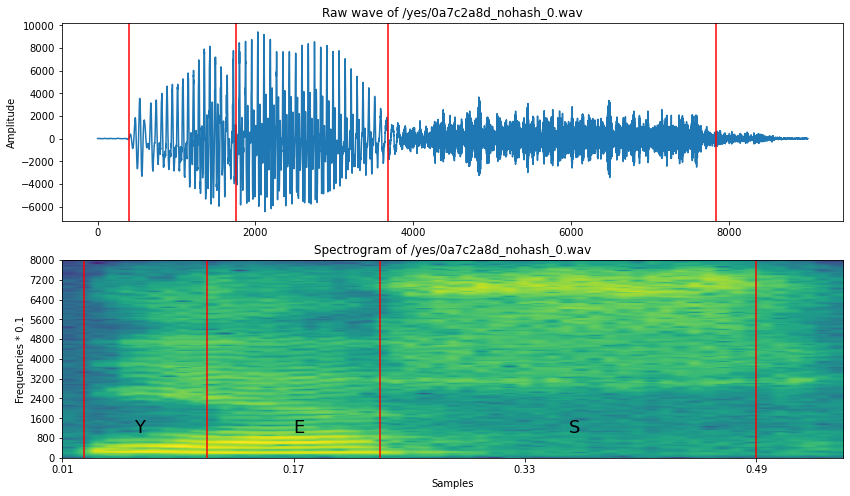

In [81]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

## 1.5. Resampling - dimensionality reduction

In [82]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [83]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [84]:
ipd.Audio(samples, rate=sample_rate)

In [85]:
ipd.Audio(resampled, rate=new_sample_rate)


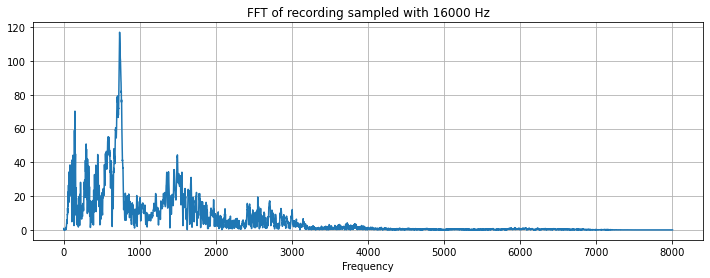

In [86]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

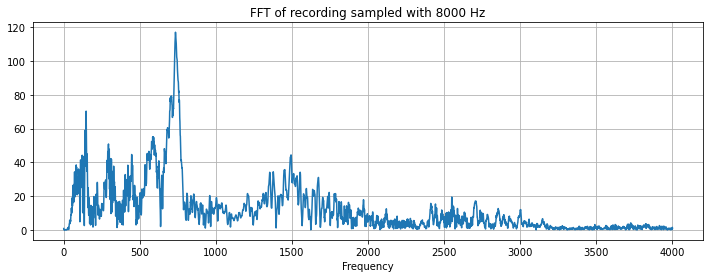

In [87]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

## 1.6. Features extraction steps

"""
I would propose the feature extraction algorithm like that:

1.Resampling

2.VAD

3.Maybe padding with 0 to make signals be equal length

4.Log spectrogram (or MFCC, or PLP)

5.Features normalization with mean and std

6.Stacking of a given number of frames to get temporal information

It's a pity it can't be done in notebook. It has not much sense to write things from zero, and everything is ready to take, but in packages, that can not be imported in Kernels.
"""

# 2. Dataset investigation

## 2.1. Number of records

In [88]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 31


In [90]:
# Calculate
number_of_recordings = []
for direct in dirs:
    waves = [ f for f in os.listdir(join(train_audio_path, direct))
                if f.endswith('.wav')]
    number_of_recordings.append(len(waves))
    
# plot 
data = [go.Histogram(x=dirs, y = number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale='ylorrd',
               showscale=True),
)

layout = go.Layout(
    title='Number of recordings in given label',
    xaxis=dict(title='Words'),
    yaxis=dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))

## 2.2. Deeper into recordings

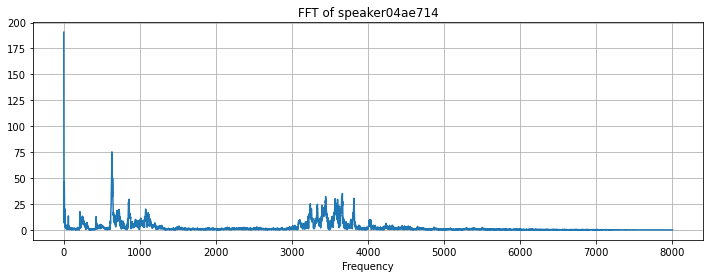

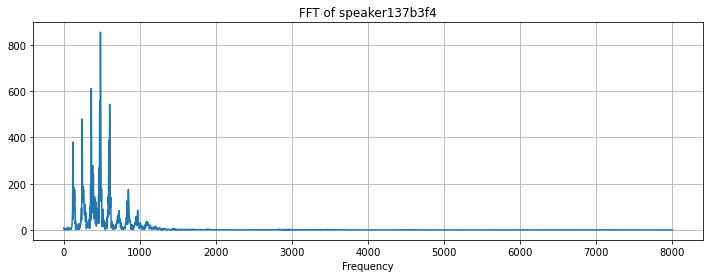

In [91]:
filenames = ['on/004ae714_nohash_0.wav', 'on/0137b3f4_nohash_0.wav']
for filename in filenames:
    sample_rate, samples = wavfile.read(str(train_audio_path) +
                                       filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12,4))
    plt.title('FFT of speaker' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

In [92]:
print('Speaker ' + filenames[0][4:11])
ipd.Audio(join(train_audio_path, filenames[0]))

Speaker 04ae714


In [93]:
print('Speaker ' + filenames[1][4:11])
ipd.Audio(join(train_audio_path, filenames[1]))

Speaker 137b3f4


In [94]:
filename = '/yes/01bb6a2a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
ipd.Audio(samples, rate = sample_rate)

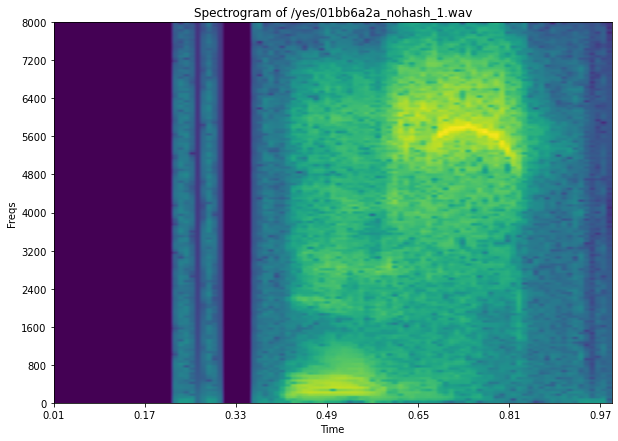

In [95]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10,7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

## 2.3. Recordings length

In [98]:
num_of_shorter= 0
for direct in dirs:
    waves= [f for f in os.listdir(join(train_audio_path, direct))
           if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path +
                                           direct + '/' + wav)

        if samples.shape[0] < sample_rate:
            num_of_shorter +=1
print('Number of recordings shorter than 1 second: '+ str(num_of_shorter))

<ipython-input-98-ed70d4cb9857>:6: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Number of recordings shorter than 1 second: 6469


## 2.4. Mean septrograms and FFT

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


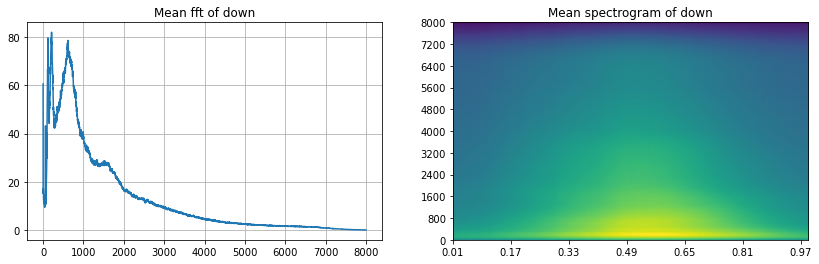

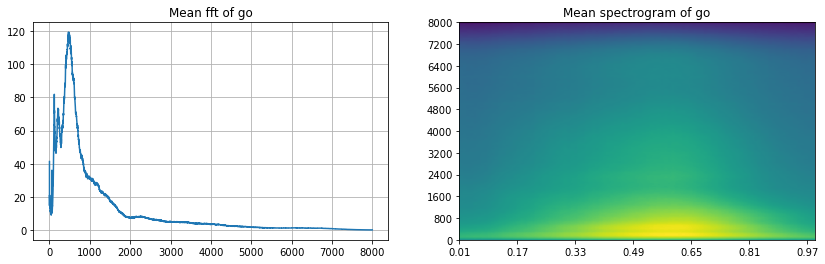

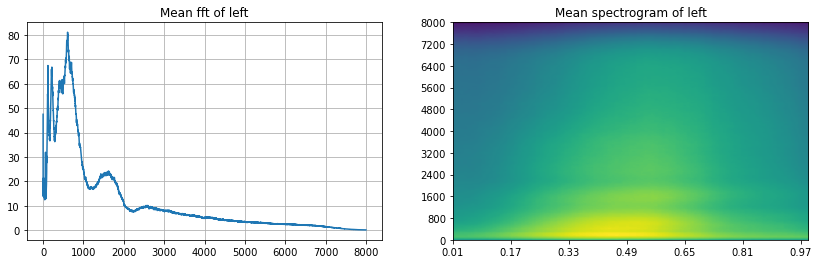

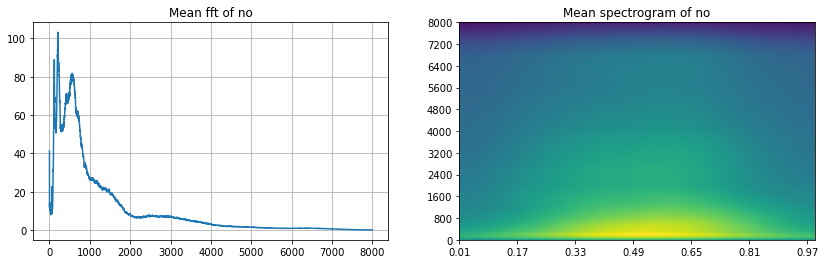

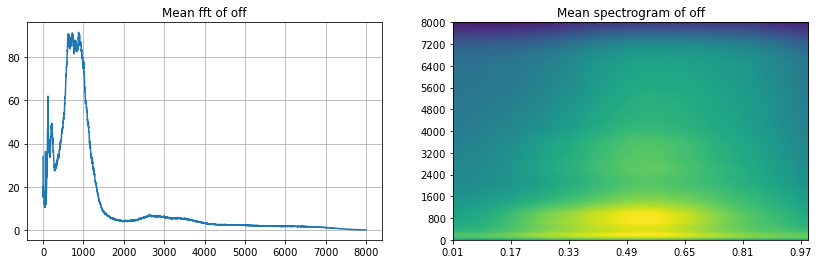

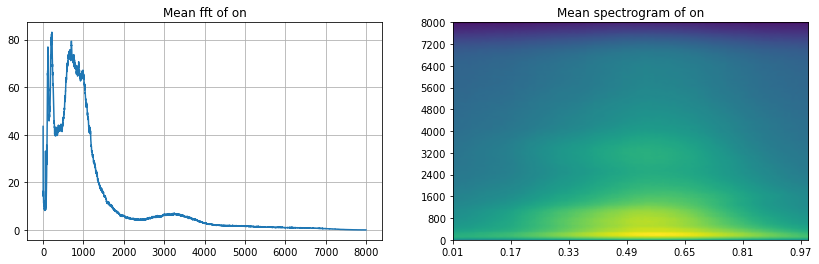

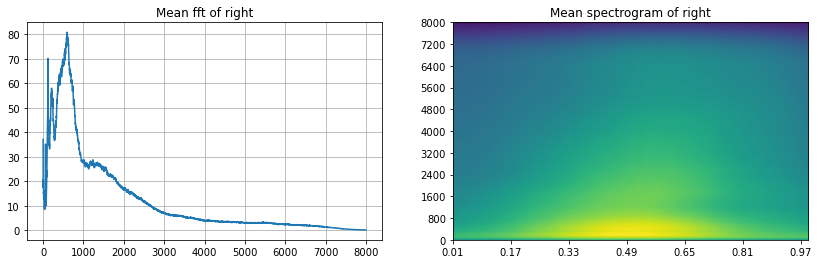

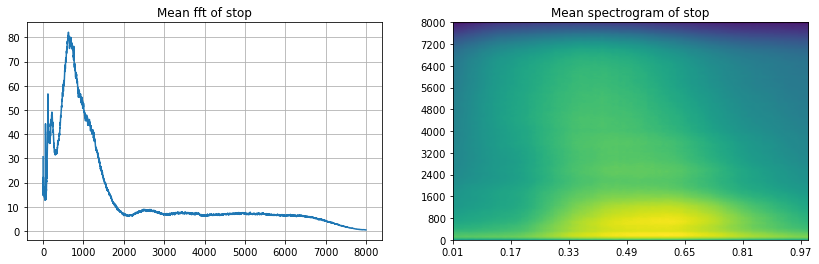

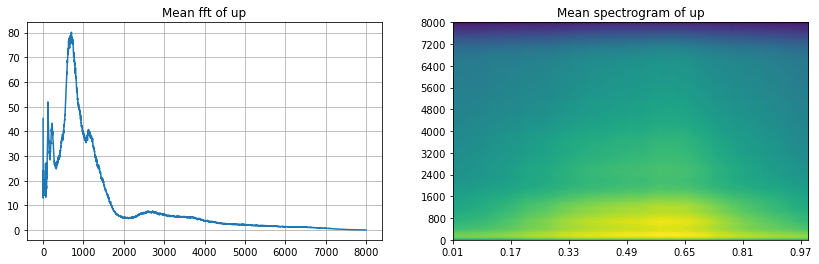

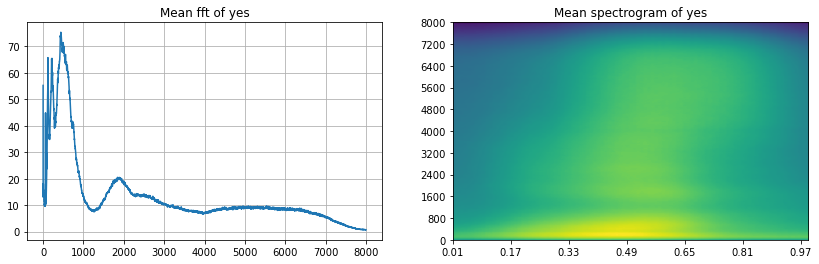

In [99]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []
    
    waves = [f for f in os.listdir(join(train_audio_path, direct))
            if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/'+wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean spectrogram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto',
               origin='lower', extent=[times.min(), times.max(),
                                       freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

## 2.5. Gaussian Mixtures modeling

We can see that mean FFT looks different for every word. We could model each FFT with a mixture of Gaussian distributions. Some of them however, look almost identical on FFT, like stop and up... But wait, they are still distinguishable when we look at spectrograms! High frequencies are earlier than low at the beginning of stop (probably s).

That's why temporal component is also necessary. There is a Kaldi library, that can model words (or smaller parts of words) with GMMs and model temporal dependencies with Hidden Markov Models.

We could use simple GMMs for words to check what can we model and how hard it is to distinguish the words. We can use Scikit-learn for that, however it is not straightforward and lasts very long here, so I abandon this idea for now.

## 2.6. Frequency components across the words

In [100]:
def violinplot_frequency(dirs, freq_ind):
    spec_all = []
    ind=0
    for direct in dirs:
        spec_all.append([])
        
        waves = [f for f in os.listdir(join(train_audio_path, direct))
                if f.endswith('.wav')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(
                train_audio_path + direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind +=1
    minimun = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimun] for spec in spec_all])
    
    plt.figure(figsize=(13,7))
    plt.title('Frequency' + str(freqs[freq_ind]) + ' Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all.T, columns=dirs))
    plt.show()

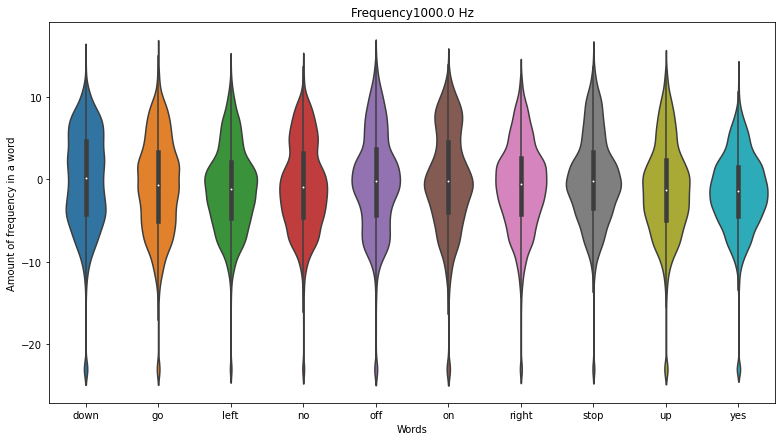

In [101]:
violinplot_frequency(dirs, 20)

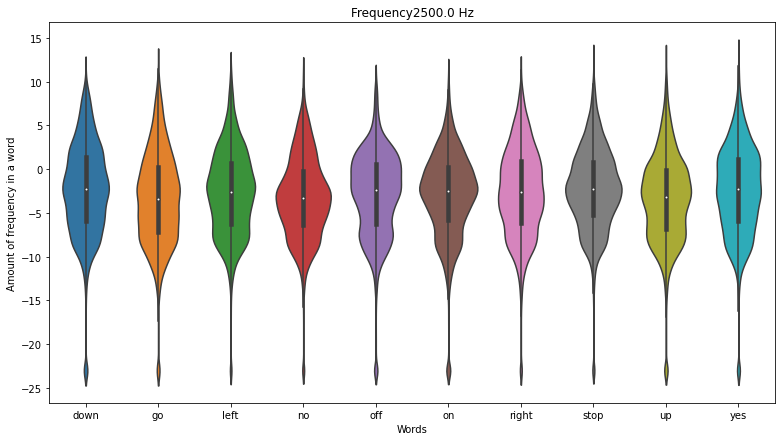

In [102]:
violinplot_frequency(dirs, 50)

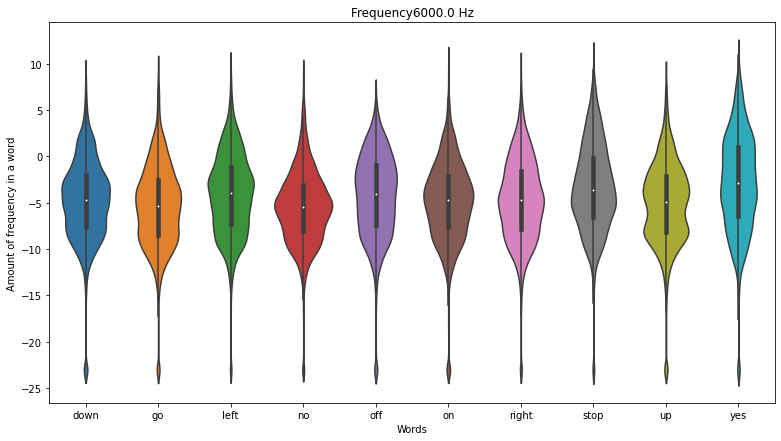

In [103]:
violinplot_frequency(dirs, 120)

## 2.7. Anomaly detection

In [104]:
fft_all = []
names = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != sample_rate:
            samples = np.append(samples, np.zeros((sample_rate - samples.shape[0], )))
        x, val = custom_fft(samples, sample_rate)
        fft_all.append(val)
        names.append(direct + '/' + wav)

fft_all = np.array(fft_all)

# Normalization
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

In [105]:
# Dim reduction
pca = PCA(n_components=3)
fft_all = pca.fit_transform(fft_all)

def interactive_3d_plot(data, names):
    scatt = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2], mode='markers', text=names)
    data = go.Data([scatt])
    layout = go.Layout(title="Anomaly detection")
    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure)
    
interactive_3d_plot(fft_all, names)

C:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




In [106]:
print('Recording go/0487ba9b_nohash_0.wav')
ipd.Audio(join(train_audio_path,'go/0487ba9b_nohash_0.wav'))

Recording go/0487ba9b_nohash_0.wav


In [107]:
print('Recording yes/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'yes/e4b02540_nohash_0.wav'))

Recording yes/e4b02540_nohash_0.wav


In [108]:
print('Recording seven/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'seven/e4b02540_nohash_0.wav'))

Recording seven/e4b02540_nohash_0.wav
